In [ ]:
import time
import random
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
from datetime import datetime, timedelta
import time
from alpha_vantage.timeseries import TimeSeries
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import TimeSeriesSplit
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import warnings



In [ ]:
!pip install alpha_vantage

            1. open  2. high  3. low  4. close   5. volume
date                                                      
2025-05-30  199.370   201.96  196.78    200.85  70819942.0
2025-05-29  203.575   203.81  198.51    199.95  51477938.0
2025-05-28  200.590   202.73  199.90    200.42  45339678.0
2025-05-27  198.300   200.74  197.43    200.21  56288475.0
2025-05-23  193.665   197.70  193.46    195.27  78432918.0


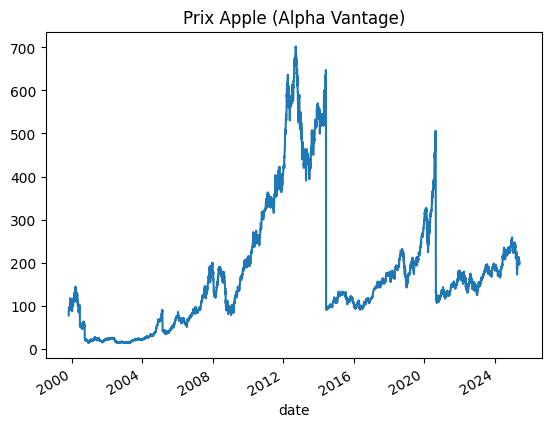

In [ ]:
#clé API gratuite sur https://www.alphavantage.co/
api_key = 'E26EF809WUN3SROE'

ts = TimeSeries(key=api_key, output_format='pandas')
data, meta_data = ts.get_daily(symbol='AAPL', outputsize='full')

print(data.head())
data['4. close'].plot(title="Prix Apple (Alpha Vantage)")
plt.show()

In [3]:
data = data.reset_index()

In [7]:
data.head(2)

,date,1. open,2. high,3. low,4. close,5. volume
0,2025-05-22,200.71,202.75,199.70,201.36,46742407.0
1,2025-05-21,205.17,207.04,200.71,202.09,59211774.0


In [ ]:
data.shape

(6423, 6)

In [4]:
data['date'] = pd.to_datetime(data['date'])
data.rename(columns={
    '1. open': 'Open',
    '2. high': 'High',
    '3. low': 'Low',
    '4. close': 'Close',
    '5. volume': 'Volume'
}, inplace=True)

#Data Cleaning & Preprocessing

In [ ]:
data.isna().sum()

,0
date,0
Open,0
High,0
Low,0
Close,0
Volume,0


In [5]:
data["Tomorrow"] = data["Close"].shift(-1)

In [6]:
data["Target"] = (data["Tomorrow"] > data["Close"]).astype(int)

In [7]:
data.head(2)

,date,Open,High,Low,Close,Volume,Tomorrow,Target
0,2025-05-30,199.370,201.96,196.78,200.85,70819942.0,199.95,0
1,2025-05-29,203.575,203.81,198.51,199.95,51477938.0,200.42,1


# RANDOM FOREST

In [10]:
model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

In [ ]:
data.shape

(6423, 8)

In [ ]:
6423*0.2

1284.6000000000001

In [12]:
train = data.iloc[:-600]
test = data.iloc[-600:]

In [13]:
predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [ ]:
preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.6030769230769231

Améliorons notre modèle


--- n_estimators=10 ---
Train Accuracy: 0.7885
Test Accuracy:  0.5833
Test Confusion Matrix:
[[148 152]
 [ 98 202]]


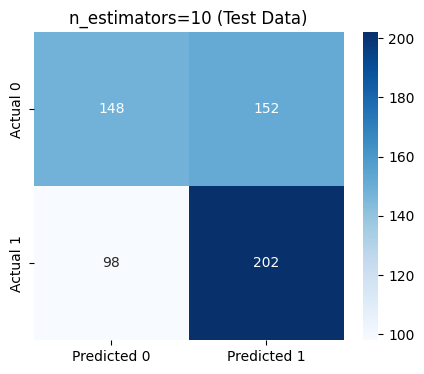


--- n_estimators=50 ---
Train Accuracy: 0.8317
Test Accuracy:  0.6200
Test Confusion Matrix:
[[170 130]
 [ 98 202]]


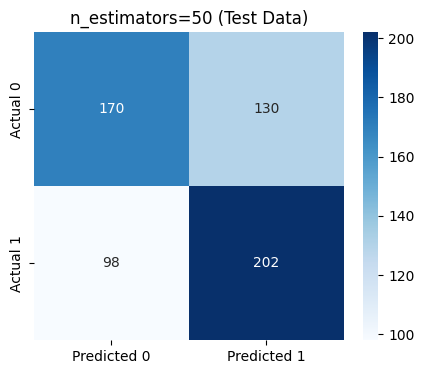


--- n_estimators=100 ---
Train Accuracy: 0.8408
Test Accuracy:  0.6217
Test Confusion Matrix:
[[177 123]
 [104 196]]


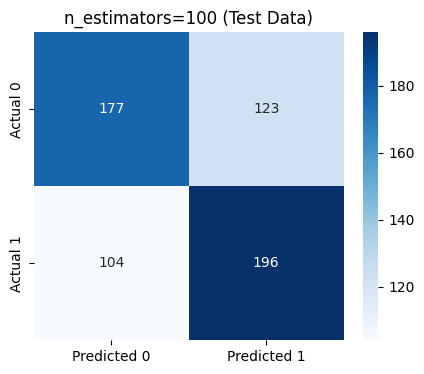


--- n_estimators=200 ---
Train Accuracy: 0.8449
Test Accuracy:  0.6250
Test Confusion Matrix:
[[179 121]
 [104 196]]


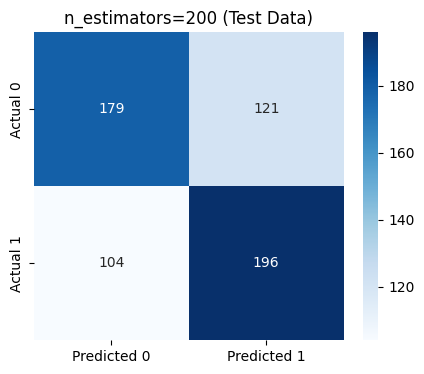


--- n_estimators=300 ---
Train Accuracy: 0.8495
Test Accuracy:  0.6200
Test Confusion Matrix:
[[173 127]
 [101 199]]


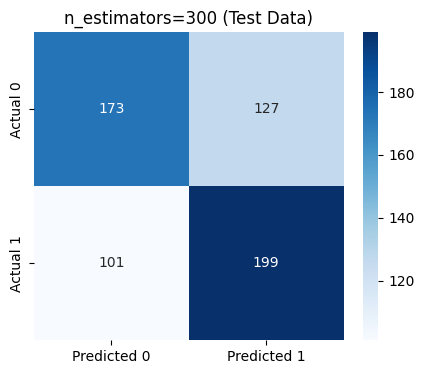


--- n_estimators=500 ---
Train Accuracy: 0.8507
Test Accuracy:  0.6300
Test Confusion Matrix:
[[174 126]
 [ 96 204]]


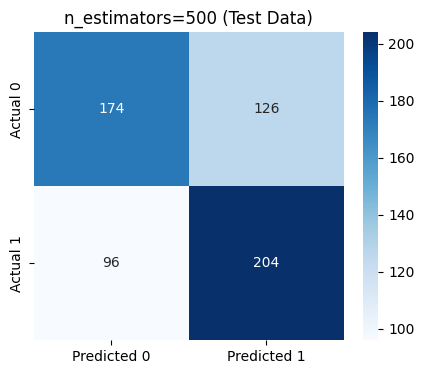

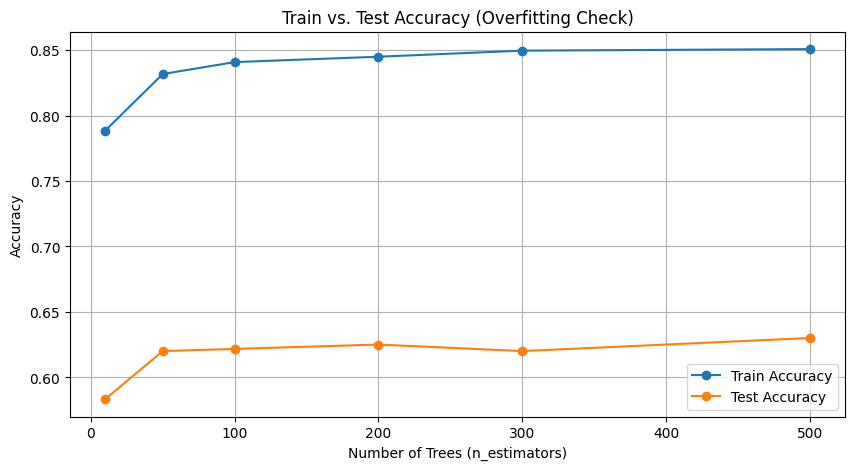

In [ ]:
n_trees = [10, 50, 100, 200, 300, 500]
train_accuracies = []
test_accuracies = []

for n in n_trees:
    model = RandomForestClassifier(n_estimators=n, min_samples_split=100, random_state=1)
    model.fit(train[predictors], train["Target"])

    train_preds = model.predict(train[predictors])
    train_acc = accuracy_score(train["Target"], train_preds)
    train_accuracies.append(train_acc)

    test_preds = model.predict(test[predictors])
    test_acc = accuracy_score(test["Target"], test_preds)
    test_accuracies.append(test_acc)


    cm = confusion_matrix(test["Target"], test_preds)

    print(f"\n--- n_estimators={n} ---")
    print(f"Train Accuracy: {train_acc:.4f}")
    print(f"Test Accuracy:  {test_acc:.4f}")
    print("Test Confusion Matrix:")
    print(cm)


    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Predicted 0", "Predicted 1"],
                yticklabels=["Actual 0", "Actual 1"])
    plt.title(f"n_estimators={n} (Test Data)")
    plt.show()

plt.figure(figsize=(10, 5))
plt.plot(n_trees, train_accuracies, label="Train Accuracy", marker="o")
plt.plot(n_trees, test_accuracies, label="Test Accuracy", marker="o")
plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("Accuracy")
plt.title("Train vs. Test Accuracy (Overfitting Check)")
plt.legend()
plt.grid(True)
plt.show()

In [15]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [16]:

def backtest(data, model, predictors, start=2000, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)

    return pd.concat(all_predictions)

In [17]:
predictions = backtest(data, model, predictors)

In [24]:
predictions["Predictions"].value_counts()

Predictions
0    3245
1    1184
Name: count, dtype: int64

In [25]:

predictions["Target"].value_counts() / predictions.shape[0]

Target
0    0.522691
1    0.477309
Name: count, dtype: float64

In [18]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >=0.6] = 1
    preds[preds <0.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [27]:
predictions = backtest(data, model, predictors)

In [28]:
precision_score(predictions["Target"], predictions["Predictions"])

0.6787003610108303

In [29]:
predictions

,Target,Predictions
2000,1,0.0
2001,0,0.0
2002,0,0.0
2003,1,0.0
2004,0,0.0
...,...,...
6424,0,0.0
6425,0,0.0
6426,0,0.0
6427,0,0.0



--- n_estimators=10 ---
Train Accuracy: 0.7051
Test Accuracy:  0.5493
Precision Score: 0.6746
Confusion Matrix:
[[2205  110]
 [1886  228]]


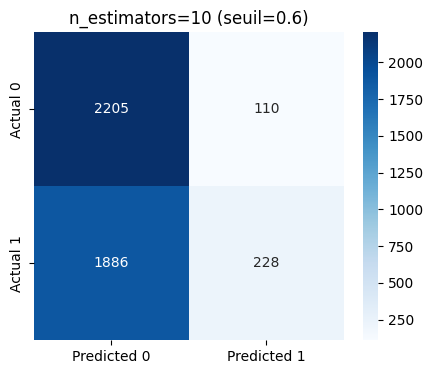


--- n_estimators=50 ---
Train Accuracy: 0.6912
Test Accuracy:  0.5493
Precision Score: 0.7682
Confusion Matrix:
[[2264   51]
 [1945  169]]


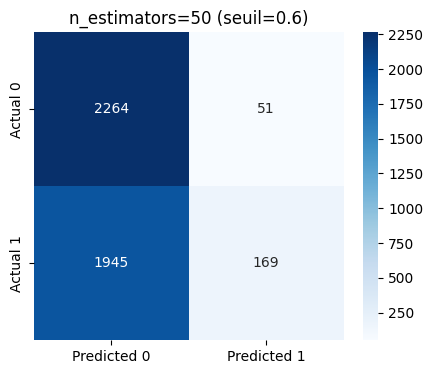


--- n_estimators=100 ---
Train Accuracy: 0.6818
Test Accuracy:  0.5478
Precision Score: 0.7876
Confusion Matrix:
[[2274   41]
 [1962  152]]


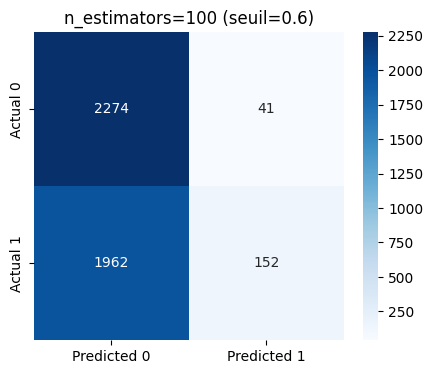


--- n_estimators=200 ---
Train Accuracy: 0.6800
Test Accuracy:  0.5473
Precision Score: 0.6912
Confusion Matrix:
[[2227   88]
 [1917  197]]


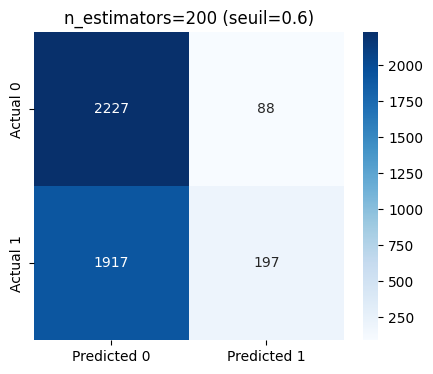


--- n_estimators=300 ---
Train Accuracy: 0.6824
Test Accuracy:  0.5464
Precision Score: 0.6882
Confusion Matrix:
[[2228   87]
 [1922  192]]


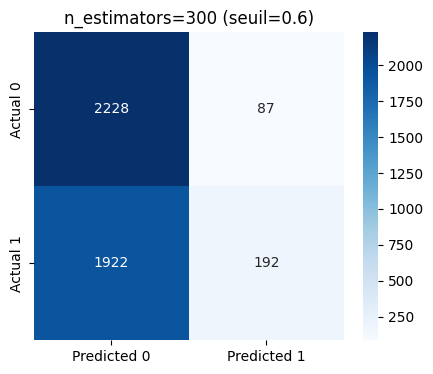


--- n_estimators=500 ---
Train Accuracy: 0.6831
Test Accuracy:  0.5450
Precision Score: 0.6787
Confusion Matrix:
[[2226   89]
 [1926  188]]


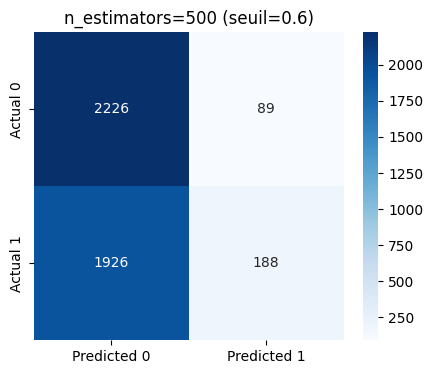

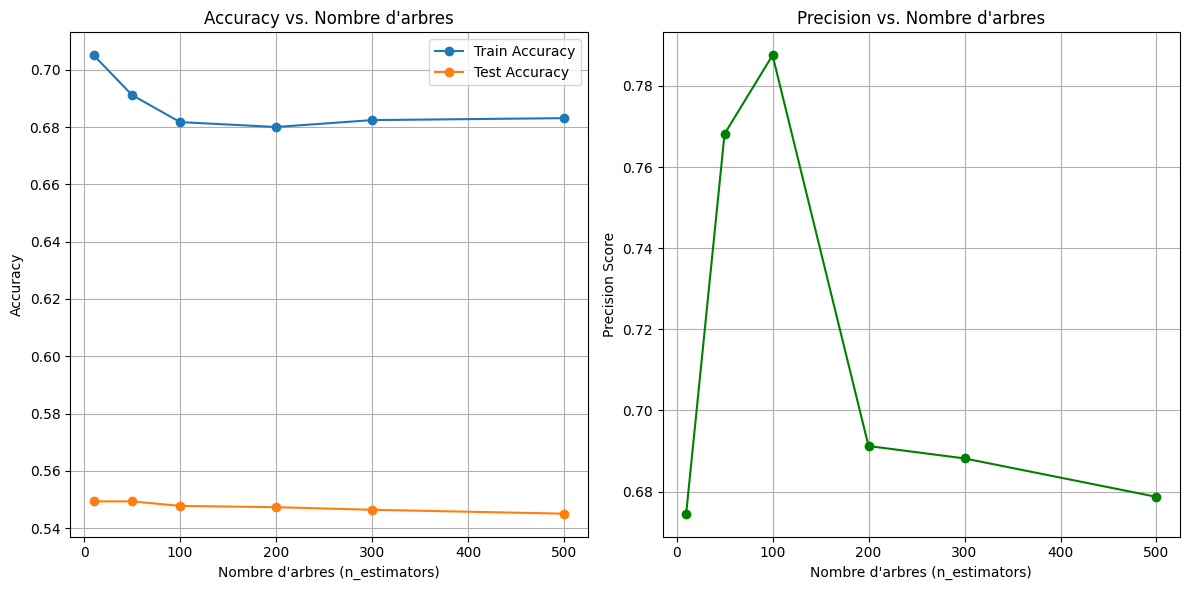

In [31]:
n_trees = [10, 50, 100, 200, 300, 500]
train_accuracies = []
test_accuracies = []
precision_scores = []

for n in n_trees:
    model = RandomForestClassifier(n_estimators=n, min_samples_split=100, random_state=1)
    
    def predict(train, test, predictors, model):
        model.fit(train[predictors], train["Target"])
        proba = model.predict_proba(test[predictors])[:,1]
        preds = proba.copy()
        preds[preds >= 0.6] = 1
        preds[preds < 0.6] = 0
        preds = pd.Series(preds, index=test.index, name="Predictions")
        proba = pd.Series(proba, index=test.index, name="Probability")
        combined = pd.concat([test["Target"], preds, proba], axis=1)
        return combined
    
    predictions = backtest(data, model, predictors, start=2000, step=250)
    
    accuracy = accuracy_score(predictions["Target"], predictions["Predictions"])
    prec_score = precision_score(predictions["Target"], predictions["Predictions"])
    test_accuracies.append(accuracy)
    precision_scores.append(prec_score)
    
    model.fit(train[predictors], train["Target"])
    train_preds = model.predict_proba(train[predictors])[:,1]
    train_preds = (train_preds >= 0.6).astype(int)
    train_acc = accuracy_score(train["Target"], train_preds)
    train_accuracies.append(train_acc)

    cm = confusion_matrix(predictions["Target"], predictions["Predictions"])
    
    print(f"\n--- n_estimators={n} ---")
    print(f"Train Accuracy: {train_acc:.4f}")
    print(f"Test Accuracy:  {accuracy:.4f}")
    print(f"Precision Score: {prec_score:.4f}")
    print("Confusion Matrix:")
    print(cm)

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Predicted 0", "Predicted 1"],
                yticklabels=["Actual 0", "Actual 1"])
    plt.title(f"n_estimators={n} (seuil=0.6)")
    plt.show()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(n_trees, train_accuracies, label="Train Accuracy", marker="o")
plt.plot(n_trees, test_accuracies, label="Test Accuracy", marker="o")
plt.xlabel("Nombre d'arbres (n_estimators)")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Nombre d'arbres")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(n_trees, precision_scores, label="Precision", marker="o", color="green")
plt.xlabel("Nombre d'arbres (n_estimators)")
plt.ylabel("Precision Score")
plt.title("Precision vs. Nombre d'arbres")
plt.grid(True)
plt.tight_layout()
plt.show()

# Autre tentative d'amélioration 


=== Analyse avec n_estimators=10 ===
Meilleur seuil: 0.30 (F1-score: 0.6296)


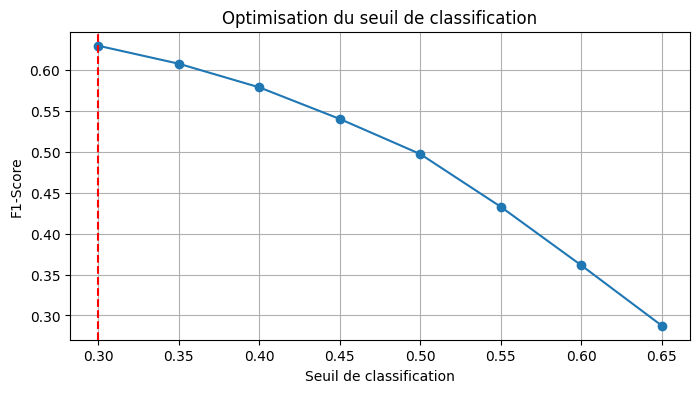

Threshold: 0.30
Accuracy: 0.4789
Precision: 0.4747
Recall: 0.9343
F1-Score: 0.6296
Matrice de confusion:
[[ 190 2579]
 [ 164 2331]]


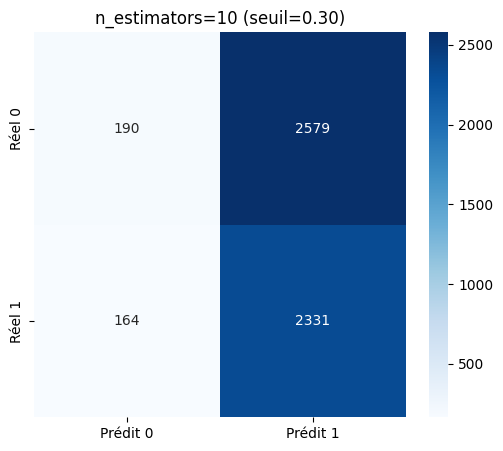

Nombre d'erreurs: 2743
Faux positifs: 2579 (94.0%)
Faux négatifs: 164 (6.0%)

=== Analyse avec n_estimators=50 ===
Meilleur seuil: 0.30 (F1-score: 0.6428)


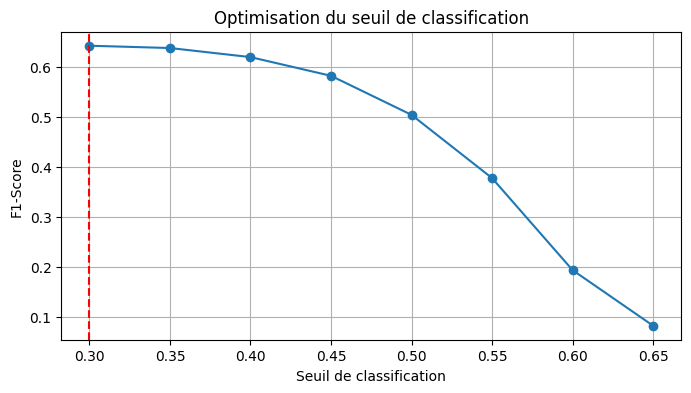

Threshold: 0.30
Accuracy: 0.4772
Precision: 0.4753
Recall: 0.9924
F1-Score: 0.6428
Matrice de confusion:
[[  36 2733]
 [  19 2476]]


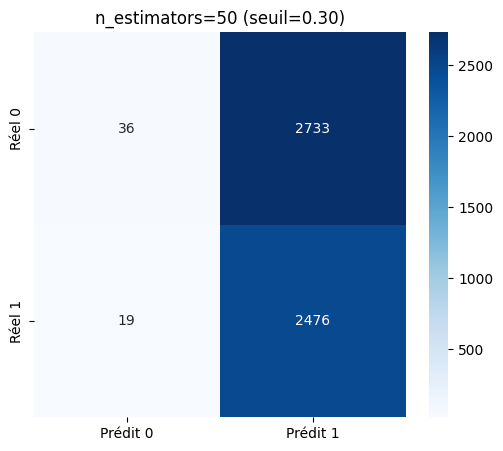

Nombre d'erreurs: 2752
Faux positifs: 2733 (99.3%)
Faux négatifs: 19 (0.7%)

=== Analyse avec n_estimators=100 ===
Meilleur seuil: 0.30 (F1-score: 0.6430)


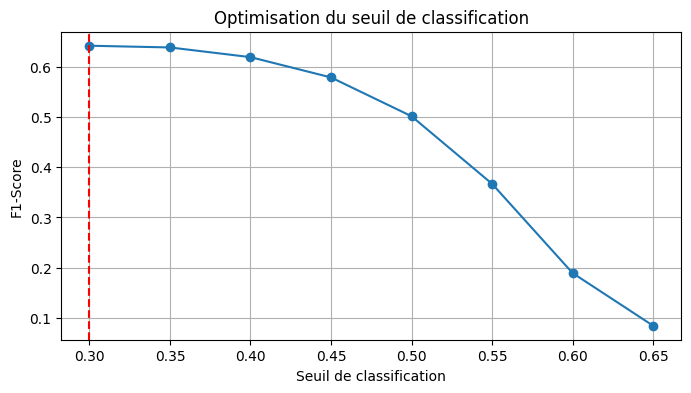

Threshold: 0.30
Accuracy: 0.4753
Precision: 0.4745
Recall: 0.9968
F1-Score: 0.6430
Matrice de confusion:
[[  15 2754]
 [   8 2487]]


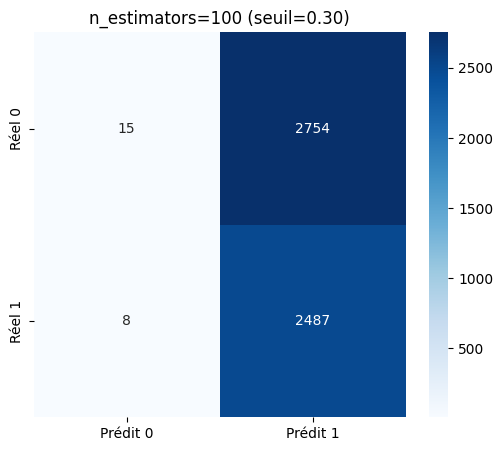

Nombre d'erreurs: 2762
Faux positifs: 2754 (99.7%)
Faux négatifs: 8 (0.3%)

=== Analyse avec n_estimators=200 ===
Meilleur seuil: 0.30 (F1-score: 0.6435)


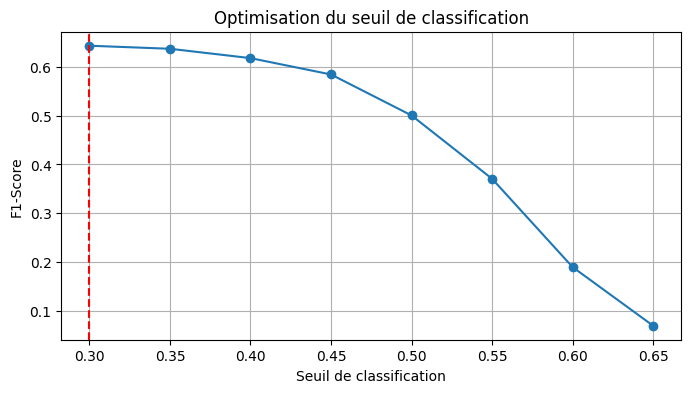

Threshold: 0.30
Accuracy: 0.4772
Precision: 0.4754
Recall: 0.9956
F1-Score: 0.6435
Matrice de confusion:
[[  28 2741]
 [  11 2484]]


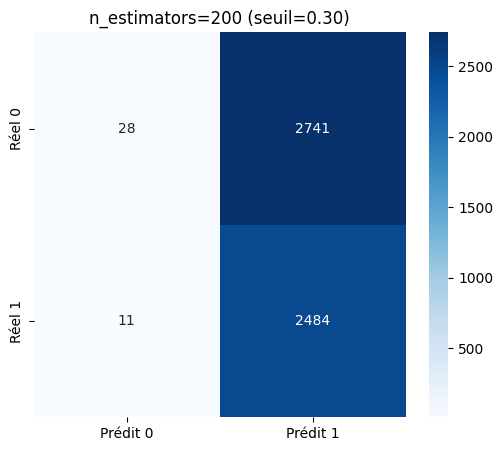

Nombre d'erreurs: 2752
Faux positifs: 2741 (99.6%)
Faux négatifs: 11 (0.4%)

=== Analyse avec n_estimators=300 ===
Meilleur seuil: 0.30 (F1-score: 0.6437)


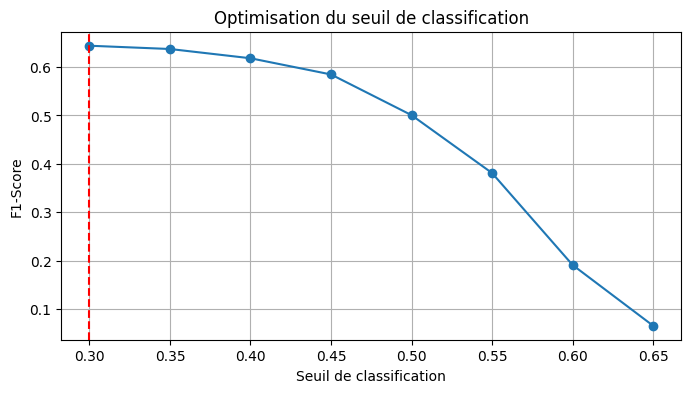

Threshold: 0.30
Accuracy: 0.4770
Precision: 0.4753
Recall: 0.9968
F1-Score: 0.6437
Matrice de confusion:
[[  24 2745]
 [   8 2487]]


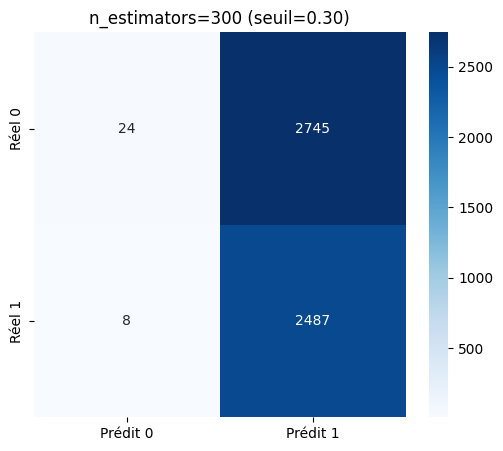

Nombre d'erreurs: 2753
Faux positifs: 2745 (99.7%)
Faux négatifs: 8 (0.3%)

=== Analyse avec n_estimators=500 ===
Meilleur seuil: 0.30 (F1-score: 0.6431)


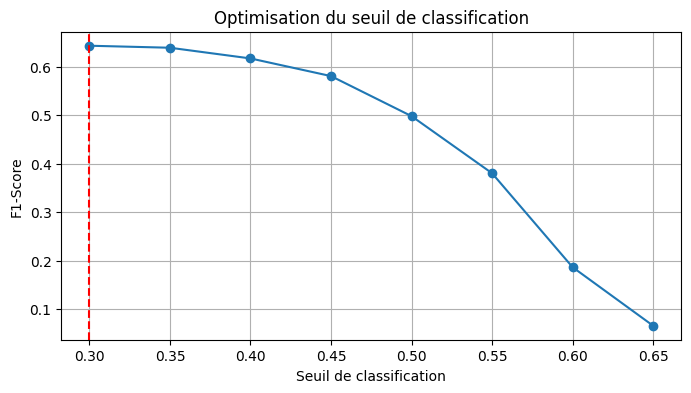

Threshold: 0.30
Accuracy: 0.4768
Precision: 0.4752
Recall: 0.9944
F1-Score: 0.6431
Matrice de confusion:
[[  29 2740]
 [  14 2481]]


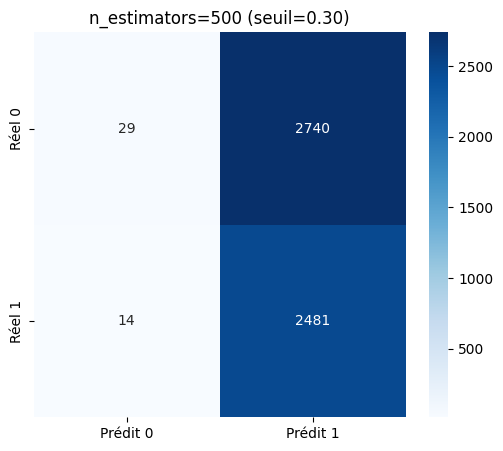

Nombre d'erreurs: 2754
Faux positifs: 2740 (99.5%)
Faux négatifs: 14 (0.5%)


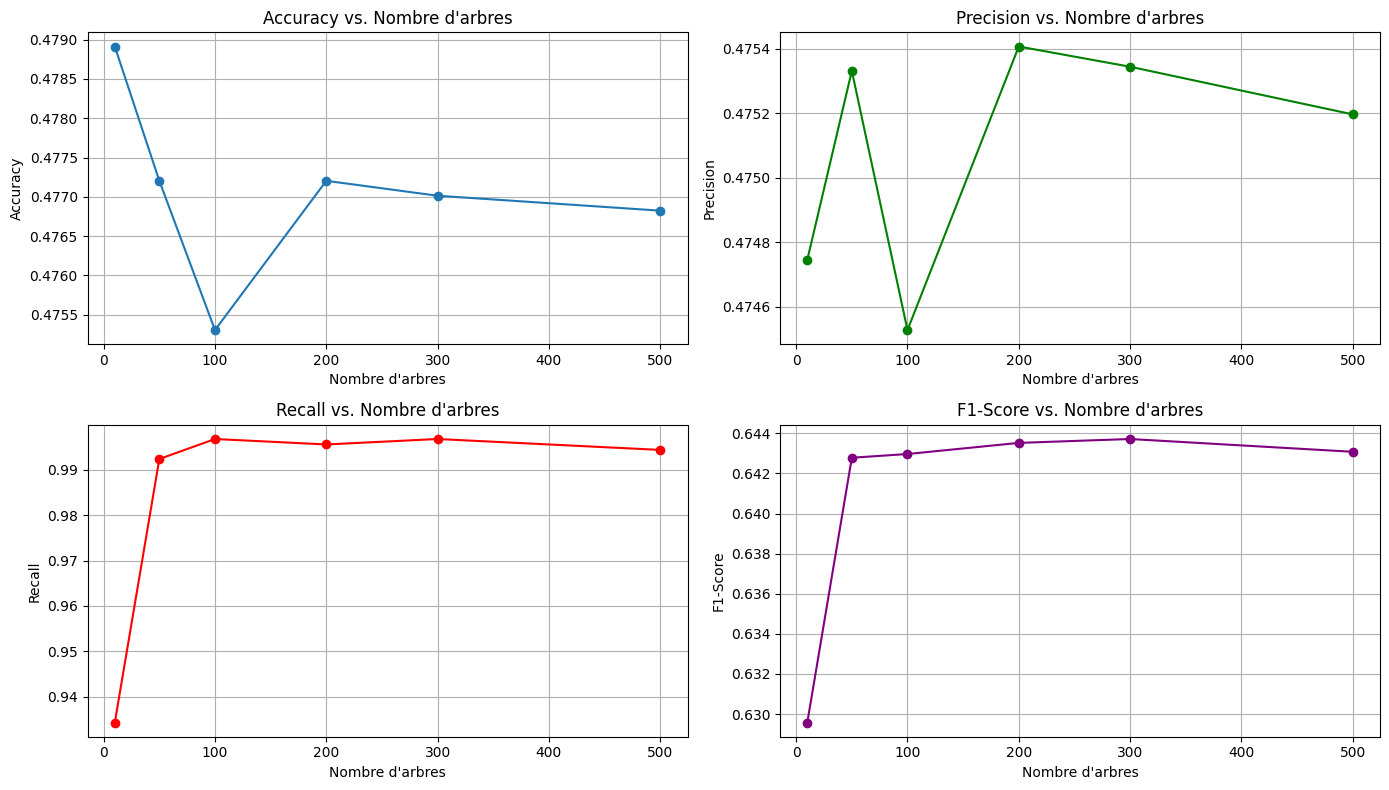


Caractéristiques les plus importantes:
                importance
PrevDayChange     0.091657
RelativeVolume    0.088106
Open              0.076353
Volume            0.073892
Momentum          0.073579
Volatility        0.071726
RSI               0.068790
MACD_Signal       0.059356
Close             0.056134
MACD              0.054818


<Figure size 1000x600 with 0 Axes>

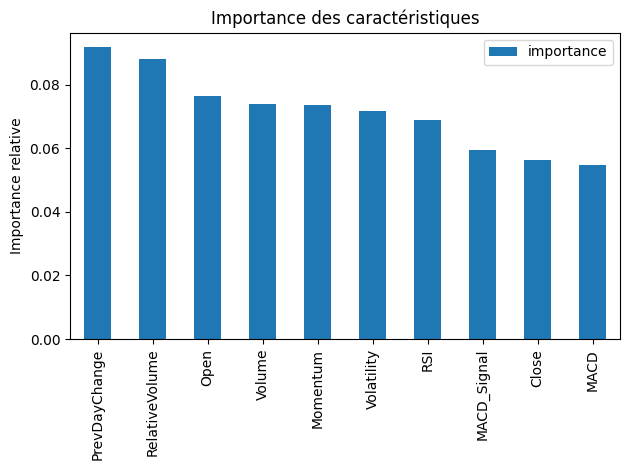


Meilleur modèle: n_estimators=300, threshold=0.30
F1-Score: 0.6437


ValueError: Found array with 0 sample(s) (shape=(0, 17)) while a minimum of 1 is required by StandardScaler.

In [ ]:
n_trees = [10, 50, 100, 200, 300, 500]
train_accuracies = []
test_accuracies = []
precision_scores = []
recall_scores = []
f1_scores = []

def add_technical_indicators(df):
    if all(col in df.columns for col in ['Close', 'High', 'Low', 'Volume']):
        df['SMA5'] = df['Close'].rolling(window=5).mean()
        df['SMA20'] = df['Close'].rolling(window=20).mean()
        delta = df['Close'].diff()
        gain = delta.where(delta > 0, 0)
        loss = -delta.where(delta < 0, 0)
        avg_gain = gain.rolling(window=14).mean()
        avg_loss = loss.rolling(window=14).mean()
        rs = avg_gain / avg_loss
        df['RSI'] = 100 - (100 / (1 + rs))
        ema12 = df['Close'].ewm(span=12, adjust=False).mean()
        ema26 = df['Close'].ewm(span=26, adjust=False).mean()
        df['MACD'] = ema12 - ema26
        df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
        df['BB_Middle'] = df['Close'].rolling(window=20).mean()
        df['BB_Upper'] = df['BB_Middle'] + 2 * df['Close'].rolling(window=20).std()
        df['BB_Lower'] = df['BB_Middle'] - 2 * df['Close'].rolling(window=20).std()
        df['Volatility'] = df['Close'].rolling(window=10).std()
        df['Momentum'] = df['Close'] - df['Close'].shift(5)
        df['PrevDayChange'] = df['Close'].pct_change()
        df['RelativeVolume'] = df['Volume'] / df['Volume'].rolling(window=20).mean()
    return df

def handle_missing_data(df):
    return df.dropna()

def time_series_cv_backtest(data, model, predictors, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    all_test_sets = []
    scaler = StandardScaler()
    last_features = None
    for train_idx, test_idx in tscv.split(data):
        train = data.iloc[train_idx].copy()
        test = data.iloc[test_idx].copy()
        train = add_technical_indicators(train)
        test = add_technical_indicators(test)
        train = handle_missing_data(train)
        test = handle_missing_data(test)
        available_predictors = [col for col in predictors if col in train.columns]
        additional_predictors = [col for col in train.columns if col not in ['Target', 'Tomorrow', 'date']
                                 and col not in available_predictors and not pd.isna(train[col]).any()]
        enhanced_predictors = available_predictors + additional_predictors
        X_train = train[enhanced_predictors]
        y_train = train['Target']
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(test[enhanced_predictors])
        if y_train.mean() < 0.4:
            try:
                smote = SMOTE(random_state=42)
                X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)
                model.fit(X_train_resampled, y_train_resampled)
            except:
                model.fit(X_train_scaled, y_train)
        else:
            model.fit(X_train_scaled, y_train)
        proba = model.predict_proba(X_test_scaled)[:, 1]
        test_result = test.copy()
        test_result['Probability'] = proba
        test_result['used_features'] = [enhanced_predictors] * len(test_result)
        all_test_sets.append(test_result)
        last_features = enhanced_predictors  # On garde la dernière liste de features utilisée
    combined_results = pd.concat(all_test_sets)
    return combined_results, last_features

def find_optimal_threshold(results):
    thresholds = np.arange(0.3, 0.7, 0.05)
    f1_values = []
    for threshold in thresholds:
        preds = results['Probability'].copy()
        preds[preds >= threshold] = 1
        preds[preds < threshold] = 0
        f1 = f1_score(results['Target'], preds)
        f1_values.append(f1)
    best_threshold = thresholds[np.argmax(f1_values)]
    print(f"Meilleur seuil: {best_threshold:.2f} (F1-score: {max(f1_values):.4f})")
    plt.figure(figsize=(8, 4))
    plt.plot(thresholds, f1_values, marker='o')
    plt.axvline(x=best_threshold, color='red', linestyle='--')
    plt.xlabel('Seuil de classification')
    plt.ylabel('F1-Score')
    plt.title('Optimisation du seuil de classification')
    plt.grid(True)
    plt.show()
    return best_threshold

best_model = None
best_f1 = 0
best_threshold = 0.5
best_features = None

for n in n_trees:
    print(f"\n=== Analyse avec n_estimators={n} ===")
    model = RandomForestClassifier(
        n_estimators=n,
        min_samples_split=50,
        random_state=1,
        class_weight='balanced',
        max_features='sqrt'
    )
    results, used_features = time_series_cv_backtest(data, model, predictors)
    threshold = find_optimal_threshold(results)
    preds = results['Probability'].copy()
    preds[preds >= threshold] = 1
    preds[preds < threshold] = 0
    acc = accuracy_score(results['Target'], preds)
    prec = precision_score(results['Target'], preds)
    rec = recall_score(results['Target'], preds)
    f1 = f1_score(results['Target'], preds)
    test_accuracies.append(acc)
    precision_scores.append(prec)
    recall_scores.append(rec)
    f1_scores.append(f1)
    if f1 > best_f1:
        best_f1 = f1
        best_model = model
        best_threshold = threshold
        best_features = used_features
    cm = confusion_matrix(results['Target'], preds)
    print(f"Threshold: {threshold:.2f}")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print("Matrice de confusion:")
    print(cm)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Prédit 0", "Prédit 1"],
                yticklabels=["Réel 0", "Réel 1"])
    plt.title(f"n_estimators={n} (seuil={threshold:.2f})")
    plt.show()
    results['Predictions'] = preds
    errors = results[results['Predictions'] != results['Target']]
    if len(errors) > 0:
        print(f"Nombre d'erreurs: {len(errors)}")
        fp = errors[(errors['Predictions'] == 1) & (errors['Target'] == 0)]
        fn = errors[(errors['Predictions'] == 0) & (errors['Target'] == 1)]
        print(f"Faux positifs: {len(fp)} ({len(fp)/len(errors)*100:.1f}%)")
        print(f"Faux négatifs: {len(fn)} ({len(fn)/len(errors)*100:.1f}%)")

plt.figure(figsize=(14, 8))
plt.subplot(2, 2, 1)
plt.plot(n_trees, test_accuracies, marker='o')
plt.xlabel("Nombre d'arbres")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Nombre d'arbres")
plt.grid(True)
plt.subplot(2, 2, 2)
plt.plot(n_trees, precision_scores, marker='o', color='green')
plt.xlabel("Nombre d'arbres")
plt.ylabel("Precision")
plt.title("Precision vs. Nombre d'arbres")
plt.grid(True)
plt.subplot(2, 2, 3)
plt.plot(n_trees, recall_scores, marker='o', color='red')
plt.xlabel("Nombre d'arbres")
plt.ylabel("Recall")
plt.title("Recall vs. Nombre d'arbres")
plt.grid(True)
plt.subplot(2, 2, 4)
plt.plot(n_trees, f1_scores, marker='o', color='purple')
plt.xlabel("Nombre d'arbres")
plt.ylabel("F1-Score")
plt.title("F1-Score vs. Nombre d'arbres")
plt.grid(True)
plt.tight_layout()
plt.show()

if best_model and best_features:
    feature_importances = pd.DataFrame(
        best_model.feature_importances_,
        index=best_features,
        columns=['importance']
    ).sort_values('importance', ascending=False)
    print("\nCaractéristiques les plus importantes:")
    print(feature_importances.head(10))
    plt.figure(figsize=(10, 6))
    feature_importances.head(10).plot(kind='bar')
    plt.title('Importance des caractéristiques')
    plt.ylabel('Importance relative')
    plt.tight_layout()
    plt.show()
    print(f"\nMeilleur modèle: n_estimators={n_trees[f1_scores.index(best_f1)]}, threshold={best_threshold:.2f}")
    print(f"F1-Score: {best_f1:.4f}")

# Optionnel : backtest avec fenêtre glissante de 15 ou 30 jours
def sliding_window_backtest(data, model, predictors, window_size=30, step=1):
    all_results = []
    scaler = StandardScaler()
    for start in range(0, len(data) - window_size, step):
        train = data.iloc[start:start+window_size].copy()
        test = data.iloc[start+window_size:start+window_size+1].copy()
        if len(test) == 0:
            break
        train = add_technical_indicators(train)
        test = add_technical_indicators(test)
        train = handle_missing_data(train)
        test = handle_missing_data(test)
        available_predictors = [col for col in predictors if col in train.columns]
        additional_predictors = [col for col in train.columns if col not in ['Target', 'Tomorrow', 'date']
                                 and col not in available_predictors and not pd.isna(train[col]).any()]
        enhanced_predictors = available_predictors + additional_predictors
        X_train = train[enhanced_predictors]
        y_train = train['Target']
        X_test = test[enhanced_predictors]
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        if y_train.mean() < 0.4:
            try:
                smote = SMOTE(random_state=42)
                X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)
                model.fit(X_train_resampled, y_train_resampled)
            except:
                model.fit(X_train_scaled, y_train)
        else:
            model.fit(X_train_scaled, y_train)
        proba = model.predict_proba(X_test_scaled)[:, 1]
        test_result = test.copy()
        test_result['Probability'] = proba
        all_results.append(test_result)
    return pd.concat(all_results)

results_15 = sliding_window_backtest(data, best_model, best_features, window_size=15)
# results_30 = sliding_window_backtest(data, best_model, best_features, window_size=30)


=== Analyse avec n_estimators=10 ===
Meilleur seuil: 0.30 (F1-score: 0.6296)


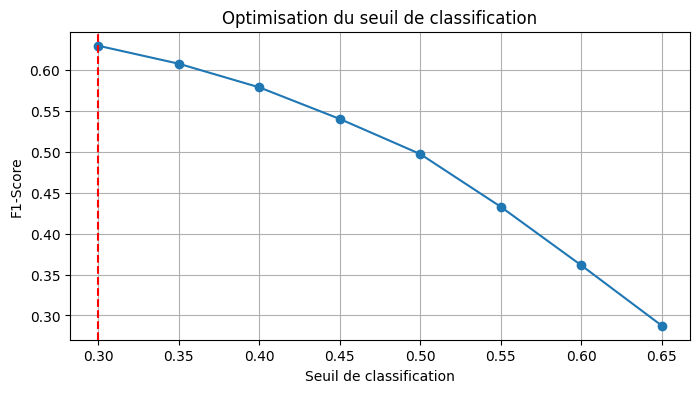

Threshold: 0.30
Accuracy: 0.4789
Precision: 0.4747
Recall: 0.9343
F1-Score: 0.6296
Matrice de confusion:
[[ 190 2579]
 [ 164 2331]]


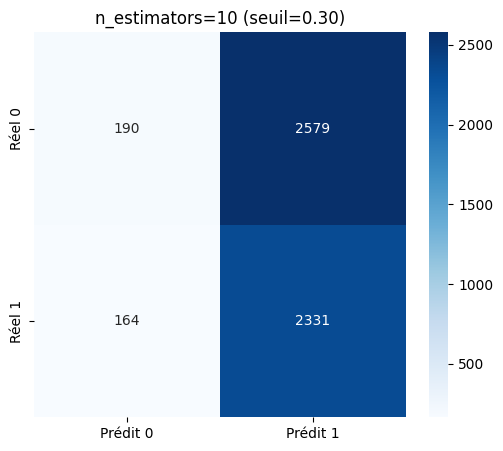

Nombre d'erreurs: 2743
Faux positifs: 2579 (94.0%)
Faux négatifs: 164 (6.0%)

=== Analyse avec n_estimators=50 ===
Meilleur seuil: 0.30 (F1-score: 0.6428)


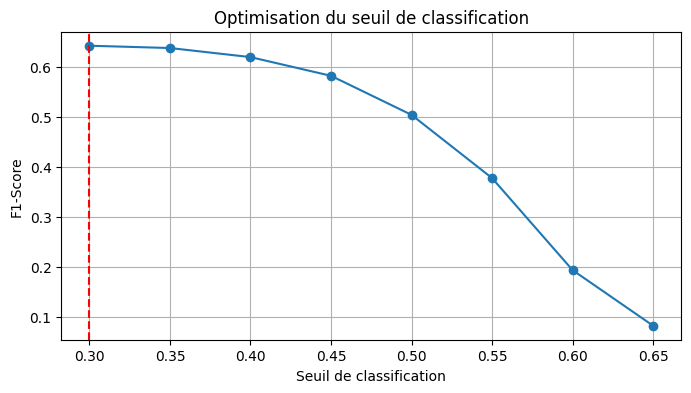

Threshold: 0.30
Accuracy: 0.4772
Precision: 0.4753
Recall: 0.9924
F1-Score: 0.6428
Matrice de confusion:
[[  36 2733]
 [  19 2476]]


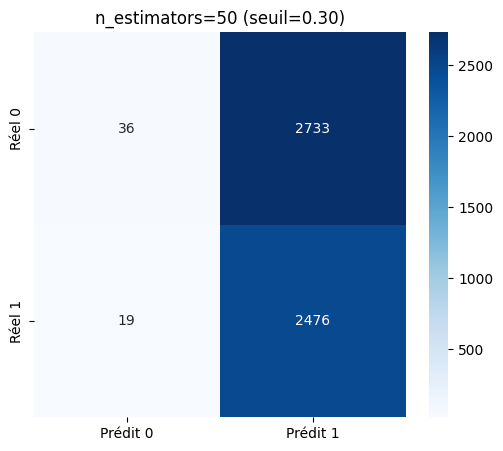

Nombre d'erreurs: 2752
Faux positifs: 2733 (99.3%)
Faux négatifs: 19 (0.7%)

=== Analyse avec n_estimators=100 ===
Meilleur seuil: 0.30 (F1-score: 0.6430)


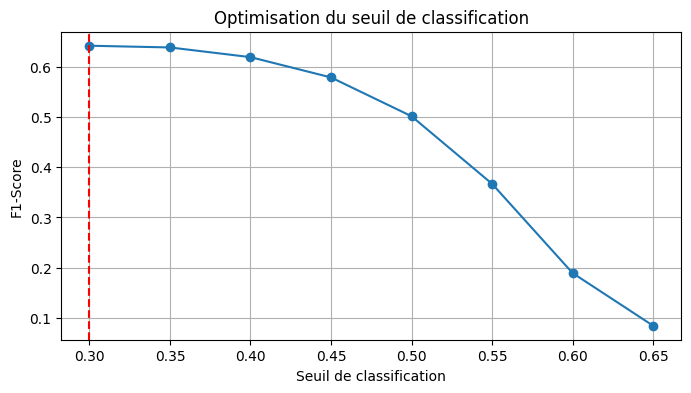

Threshold: 0.30
Accuracy: 0.4753
Precision: 0.4745
Recall: 0.9968
F1-Score: 0.6430
Matrice de confusion:
[[  15 2754]
 [   8 2487]]


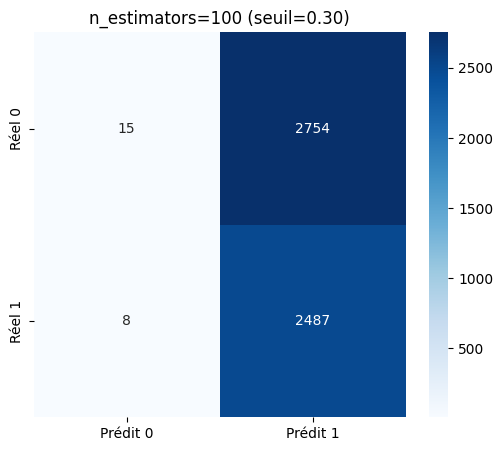

Nombre d'erreurs: 2762
Faux positifs: 2754 (99.7%)
Faux négatifs: 8 (0.3%)

=== Analyse avec n_estimators=200 ===
Meilleur seuil: 0.30 (F1-score: 0.6435)


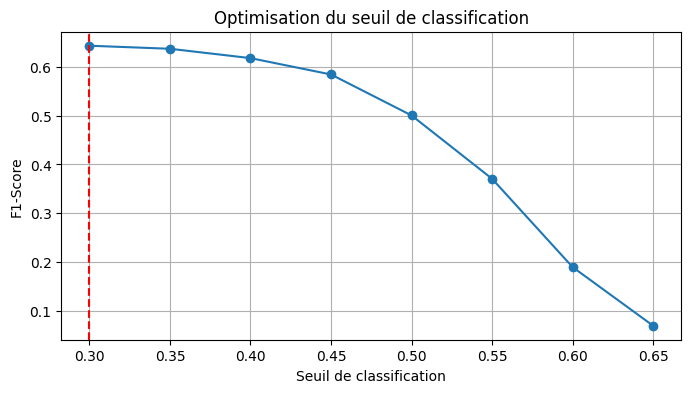

Threshold: 0.30
Accuracy: 0.4772
Precision: 0.4754
Recall: 0.9956
F1-Score: 0.6435
Matrice de confusion:
[[  28 2741]
 [  11 2484]]


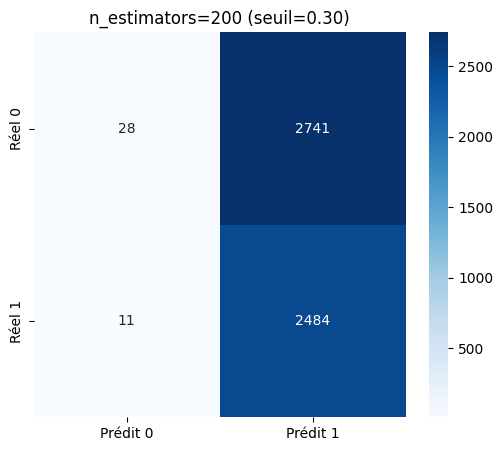

Nombre d'erreurs: 2752
Faux positifs: 2741 (99.6%)
Faux négatifs: 11 (0.4%)

=== Analyse avec n_estimators=300 ===
Meilleur seuil: 0.30 (F1-score: 0.6437)


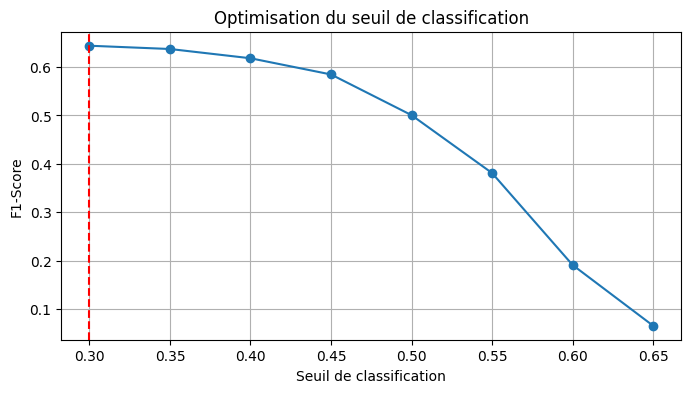

Threshold: 0.30
Accuracy: 0.4770
Precision: 0.4753
Recall: 0.9968
F1-Score: 0.6437
Matrice de confusion:
[[  24 2745]
 [   8 2487]]


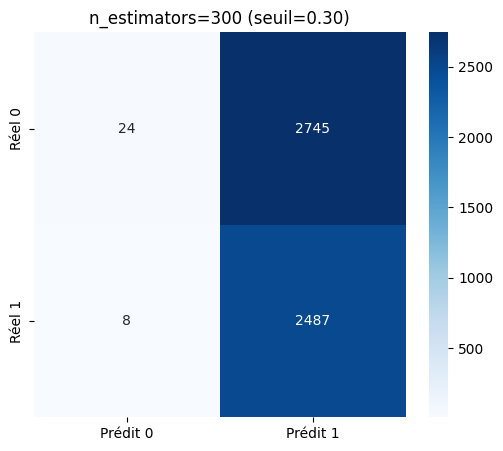

Nombre d'erreurs: 2753
Faux positifs: 2745 (99.7%)
Faux négatifs: 8 (0.3%)

=== Analyse avec n_estimators=500 ===
Meilleur seuil: 0.30 (F1-score: 0.6431)


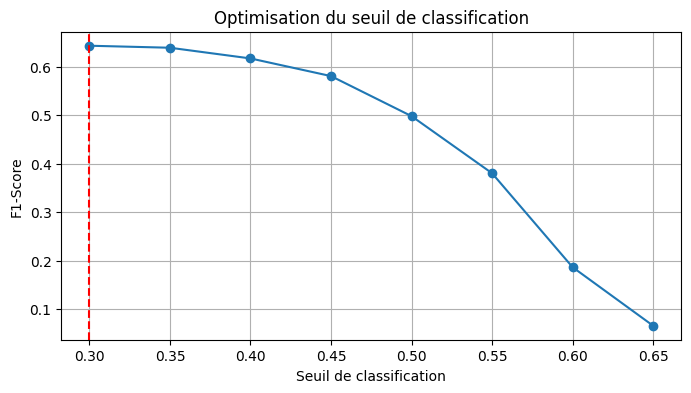

Threshold: 0.30
Accuracy: 0.4768
Precision: 0.4752
Recall: 0.9944
F1-Score: 0.6431
Matrice de confusion:
[[  29 2740]
 [  14 2481]]


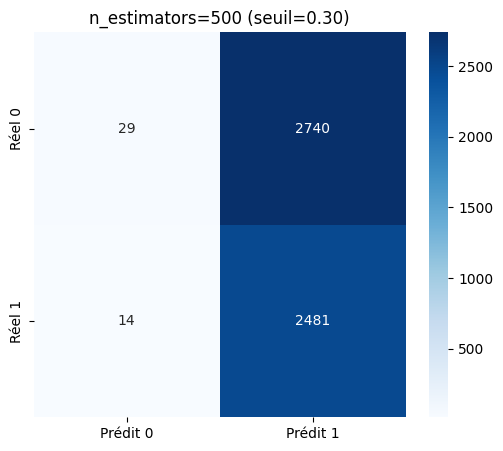

Nombre d'erreurs: 2754
Faux positifs: 2740 (99.5%)
Faux négatifs: 14 (0.5%)


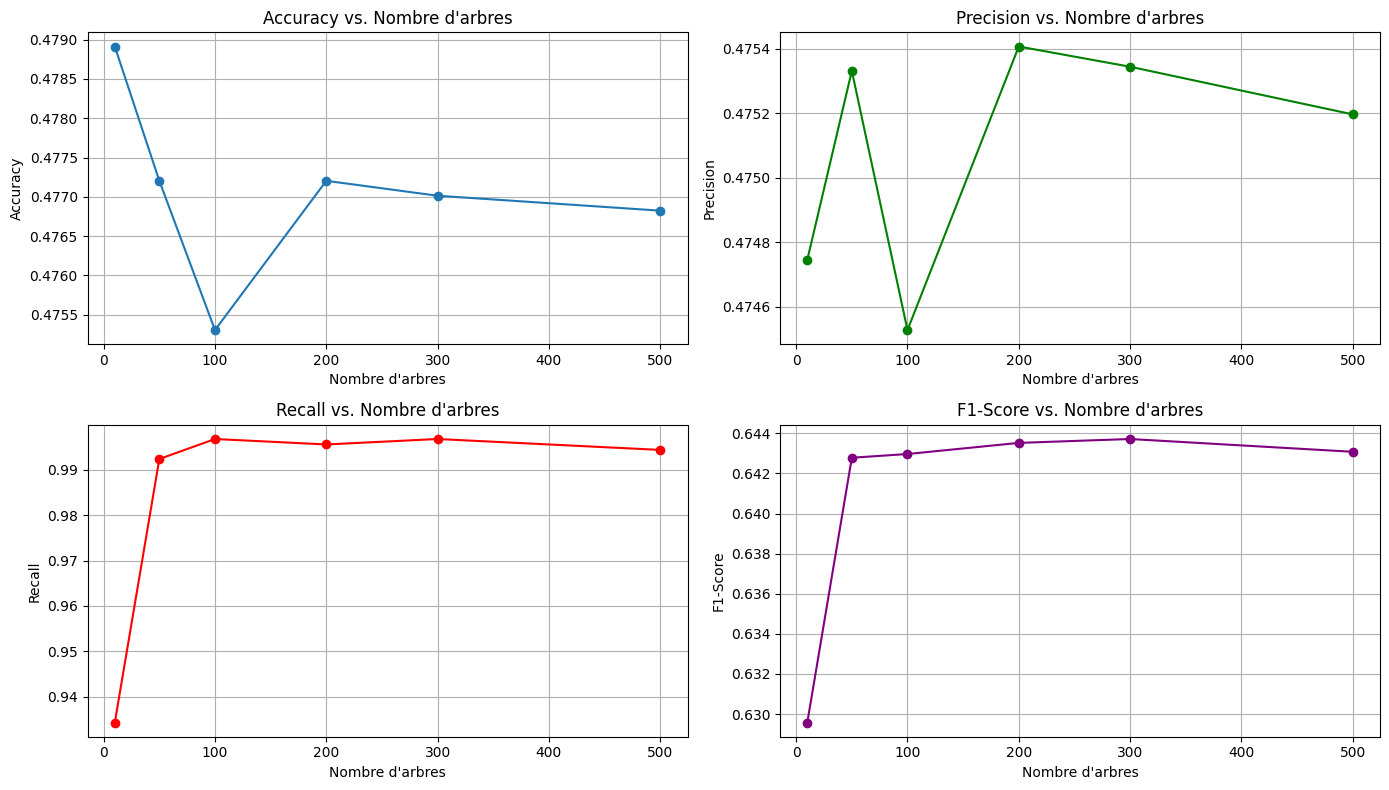


Caractéristiques les plus importantes:
                importance
PrevDayChange     0.091657
RelativeVolume    0.088106
Open              0.076353
Volume            0.073892
Momentum          0.073579
Volatility        0.071726
RSI               0.068790
MACD_Signal       0.059356
Close             0.056134
MACD              0.054818


<Figure size 1000x600 with 0 Axes>

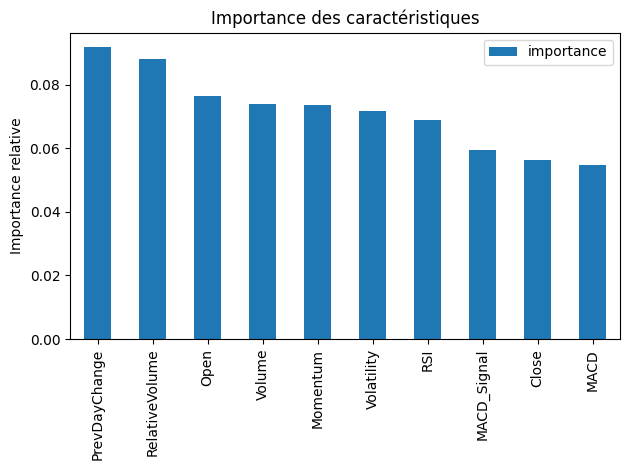


Meilleur modèle: n_estimators=300, threshold=0.30
F1-Score: 0.6437


In [ ]:
n_trees = [10, 50, 100, 200, 300, 500]
train_accuracies = []
test_accuracies = []
precision_scores = []
recall_scores = []
f1_scores = []

def add_technical_indicators(df):
    if all(col in df.columns for col in ['Close', 'High', 'Low', 'Volume']):
        df['SMA5'] = df['Close'].rolling(window=5).mean()
        df['SMA20'] = df['Close'].rolling(window=20).mean()
        delta = df['Close'].diff()
        gain = delta.where(delta > 0, 0)
        loss = -delta.where(delta < 0, 0)
        avg_gain = gain.rolling(window=14).mean()
        avg_loss = loss.rolling(window=14).mean()
        rs = avg_gain / avg_loss
        df['RSI'] = 100 - (100 / (1 + rs))
        ema12 = df['Close'].ewm(span=12, adjust=False).mean()
        ema26 = df['Close'].ewm(span=26, adjust=False).mean()
        df['MACD'] = ema12 - ema26
        df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
        df['BB_Middle'] = df['Close'].rolling(window=20).mean()
        df['BB_Upper'] = df['BB_Middle'] + 2 * df['Close'].rolling(window=20).std()
        df['BB_Lower'] = df['BB_Middle'] - 2 * df['Close'].rolling(window=20).std()
        df['Volatility'] = df['Close'].rolling(window=10).std()
        df['Momentum'] = df['Close'] - df['Close'].shift(5)
        df['PrevDayChange'] = df['Close'].pct_change()
        df['RelativeVolume'] = df['Volume'] / df['Volume'].rolling(window=20).mean()
    return df

def handle_missing_data(df):
    return df.dropna()

def time_series_cv_backtest(data, model, predictors, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    all_test_sets = []
    scaler = StandardScaler()
    last_features = None
    for train_idx, test_idx in tscv.split(data):
        train = data.iloc[train_idx].copy()
        test = data.iloc[test_idx].copy()
        train = add_technical_indicators(train)
        test = add_technical_indicators(test)
        train = handle_missing_data(train)
        test = handle_missing_data(test)
        available_predictors = [col for col in predictors if col in train.columns]
        additional_predictors = [col for col in train.columns if col not in ['Target', 'Tomorrow', 'date']
                                 and col not in available_predictors and not pd.isna(train[col]).any()]
        enhanced_predictors = available_predictors + additional_predictors
        X_train = train[enhanced_predictors]
        y_train = train['Target']
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(test[enhanced_predictors])
        if y_train.mean() < 0.4:
            try:
                smote = SMOTE(random_state=42)
                X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)
                model.fit(X_train_resampled, y_train_resampled)
            except:
                model.fit(X_train_scaled, y_train)
        else:
            model.fit(X_train_scaled, y_train)
        proba = model.predict_proba(X_test_scaled)[:, 1]
        test_result = test.copy()
        test_result['Probability'] = proba
        all_test_sets.append(test_result)
        last_features = enhanced_predictors 
    combined_results = pd.concat(all_test_sets)
    return combined_results, last_features

def find_optimal_threshold(results):
    thresholds = np.arange(0.3, 0.7, 0.05)
    f1_values = []
    for threshold in thresholds:
        preds = results['Probability'].copy()
        preds[preds >= threshold] = 1
        preds[preds < threshold] = 0
        f1 = f1_score(results['Target'], preds)
        f1_values.append(f1)
    best_threshold = thresholds[np.argmax(f1_values)]
    print(f"Meilleur seuil: {best_threshold:.2f} (F1-score: {max(f1_values):.4f})")
    plt.figure(figsize=(8, 4))
    plt.plot(thresholds, f1_values, marker='o')
    plt.axvline(x=best_threshold, color='red', linestyle='--')
    plt.xlabel('Seuil de classification')
    plt.ylabel('F1-Score')
    plt.title('Optimisation du seuil de classification')
    plt.grid(True)
    plt.show()
    return best_threshold

best_model = None
best_f1 = 0
best_threshold = 0.5
best_features = None

for n in n_trees:
    print(f"\n=== Analyse avec n_estimators={n} ===")
    model = RandomForestClassifier(
        n_estimators=n,
        min_samples_split=50,
        random_state=1,
        class_weight='balanced',
        max_features='sqrt'
    )
    results, used_features = time_series_cv_backtest(data, model, predictors)
    threshold = find_optimal_threshold(results)
    preds = results['Probability'].copy()
    preds[preds >= threshold] = 1
    preds[preds < threshold] = 0
    acc = accuracy_score(results['Target'], preds)
    prec = precision_score(results['Target'], preds)
    rec = recall_score(results['Target'], preds)
    f1 = f1_score(results['Target'], preds)
    test_accuracies.append(acc)
    precision_scores.append(prec)
    recall_scores.append(rec)
    f1_scores.append(f1)
    if f1 > best_f1:
        best_f1 = f1
        best_model = model
        best_threshold = threshold
        best_features = used_features
    cm = confusion_matrix(results['Target'], preds)
    print(f"Threshold: {threshold:.2f}")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print("Matrice de confusion:")
    print(cm)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Prédit 0", "Prédit 1"],
                yticklabels=["Réel 0", "Réel 1"])
    plt.title(f"n_estimators={n} (seuil={threshold:.2f})")
    plt.show()
    results['Predictions'] = preds
    errors = results[results['Predictions'] != results['Target']]
    if len(errors) > 0:
        print(f"Nombre d'erreurs: {len(errors)}")
        fp = errors[(errors['Predictions'] == 1) & (errors['Target'] == 0)]
        fn = errors[(errors['Predictions'] == 0) & (errors['Target'] == 1)]
        print(f"Faux positifs: {len(fp)} ({len(fp)/len(errors)*100:.1f}%)")
        print(f"Faux négatifs: {len(fn)} ({len(fn)/len(errors)*100:.1f}%)")

plt.figure(figsize=(14, 8))
plt.subplot(2, 2, 1)
plt.plot(n_trees, test_accuracies, marker='o')
plt.xlabel("Nombre d'arbres")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Nombre d'arbres")
plt.grid(True)
plt.subplot(2, 2, 2)
plt.plot(n_trees, precision_scores, marker='o', color='green')
plt.xlabel("Nombre d'arbres")
plt.ylabel("Precision")
plt.title("Precision vs. Nombre d'arbres")
plt.grid(True)
plt.subplot(2, 2, 3)
plt.plot(n_trees, recall_scores, marker='o', color='red')
plt.xlabel("Nombre d'arbres")
plt.ylabel("Recall")
plt.title("Recall vs. Nombre d'arbres")
plt.grid(True)
plt.subplot(2, 2, 4)
plt.plot(n_trees, f1_scores, marker='o', color='purple')
plt.xlabel("Nombre d'arbres")
plt.ylabel("F1-Score")
plt.title("F1-Score vs. Nombre d'arbres")
plt.grid(True)
plt.tight_layout()
plt.show()

if best_model and best_features:
    feature_importances = pd.DataFrame(
        best_model.feature_importances_,
        index=best_features,
        columns=['importance']
    ).sort_values('importance', ascending=False)
    print("\nCaractéristiques les plus importantes:")
    print(feature_importances.head(10))
    plt.figure(figsize=(10, 6))
    feature_importances.head(10).plot(kind='bar')
    plt.title('Importance des caractéristiques')
    plt.ylabel('Importance relative')
    plt.tight_layout()
    plt.show()
    print(f"\nMeilleur modèle: n_estimators={n_trees[f1_scores.index(best_f1)]}, threshold={best_threshold:.2f}")
    print(f"F1-Score: {best_f1:.4f}")




--- n_estimators=10 ---
Train Accuracy: 0.7885
Test Accuracy:  0.5833
Test Confusion Matrix:
[[148 152]
 [ 98 202]]


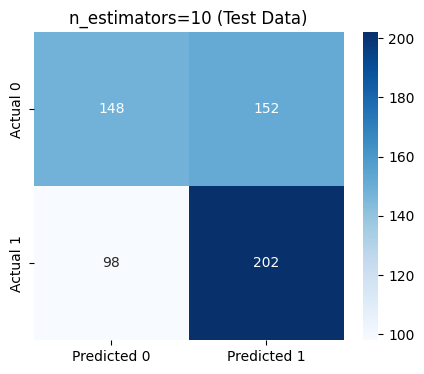


--- n_estimators=50 ---
Train Accuracy: 0.8317
Test Accuracy:  0.6200
Test Confusion Matrix:
[[170 130]
 [ 98 202]]


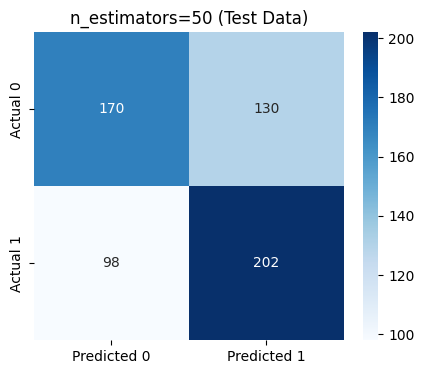


--- n_estimators=100 ---
Train Accuracy: 0.8408
Test Accuracy:  0.6217
Test Confusion Matrix:
[[177 123]
 [104 196]]


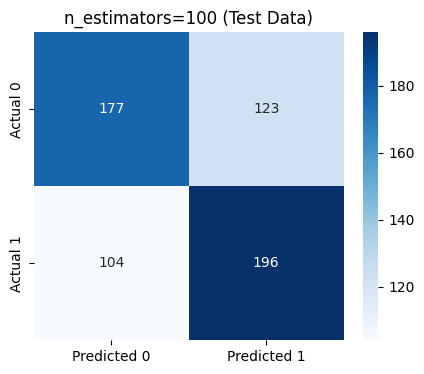


--- n_estimators=200 ---
Train Accuracy: 0.8449
Test Accuracy:  0.6250
Test Confusion Matrix:
[[179 121]
 [104 196]]


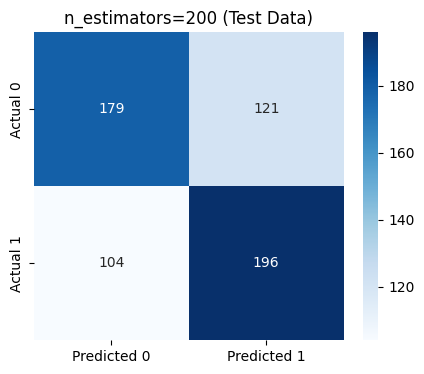


--- n_estimators=300 ---
Train Accuracy: 0.8495
Test Accuracy:  0.6200
Test Confusion Matrix:
[[173 127]
 [101 199]]


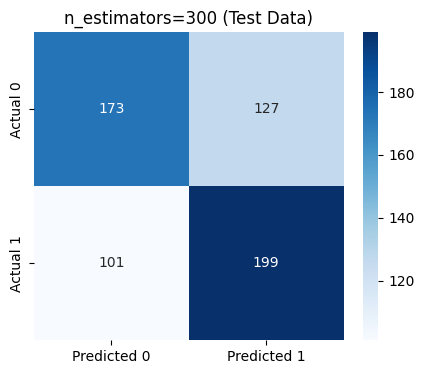


--- n_estimators=500 ---
Train Accuracy: 0.8507
Test Accuracy:  0.6300
Test Confusion Matrix:
[[174 126]
 [ 96 204]]


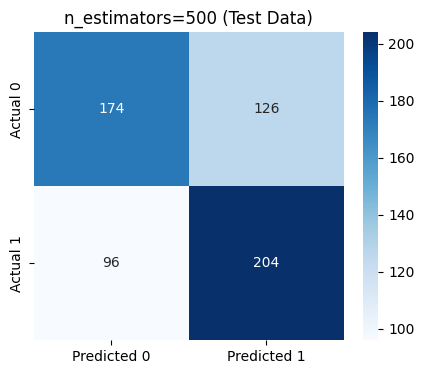

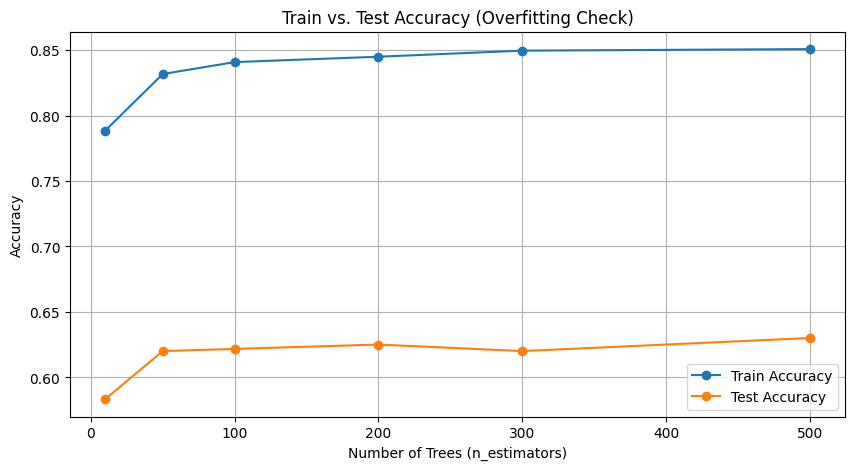

In [30]:
n_trees = [10, 50, 100, 200, 300, 500]
train_accuracies = []
test_accuracies = []

for n in n_trees:
    model = RandomForestClassifier(n_estimators=n, min_samples_split=100, random_state=1)
    model.fit(train[predictors], train["Target"])

    train_preds = model.predict(train[predictors])
    train_acc = accuracy_score(train["Target"], train_preds)
    train_accuracies.append(train_acc)

    test_preds = model.predict(test[predictors])
    test_acc = accuracy_score(test["Target"], test_preds)
    test_accuracies.append(test_acc)


    cm = confusion_matrix(test["Target"], test_preds)

    print(f"\n--- n_estimators={n} ---")
    print(f"Train Accuracy: {train_acc:.4f}")
    print(f"Test Accuracy:  {test_acc:.4f}")
    print("Test Confusion Matrix:")
    print(cm)


    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Predicted 0", "Predicted 1"],
                yticklabels=["Actual 0", "Actual 1"])
    plt.title(f"n_estimators={n} (Test Data)")
    plt.show()

plt.figure(figsize=(10, 5))
plt.plot(n_trees, train_accuracies, label="Train Accuracy", marker="o")
plt.plot(n_trees, test_accuracies, label="Test Accuracy", marker="o")
plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("Accuracy")
plt.title("Train vs. Test Accuracy (Overfitting Check)")
plt.legend()
plt.grid(True)
plt.show()

## XGBOOST

n_estimators=10:
Train Accuracy = 0.5632, Test Accuracy = 0.5145


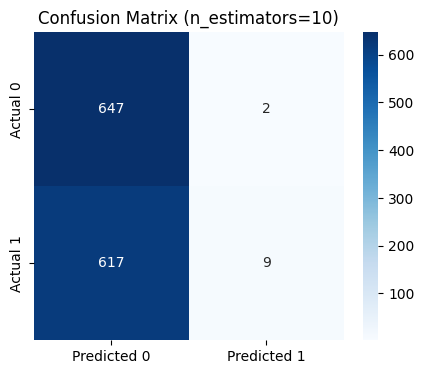

n_estimators=50:
Train Accuracy = 0.6371, Test Accuracy = 0.5294


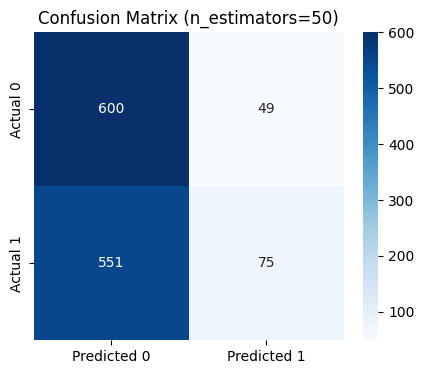

n_estimators=100:
Train Accuracy = 0.6371, Test Accuracy = 0.5294


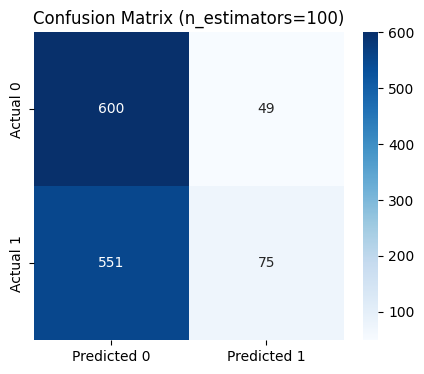

n_estimators=200:
Train Accuracy = 0.6371, Test Accuracy = 0.5294


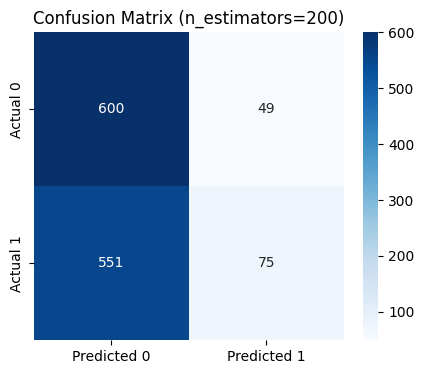

n_estimators=300:
Train Accuracy = 0.6371, Test Accuracy = 0.5294


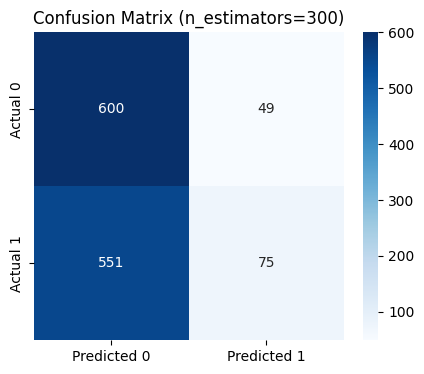

n_estimators=500:
Train Accuracy = 0.6371, Test Accuracy = 0.5294


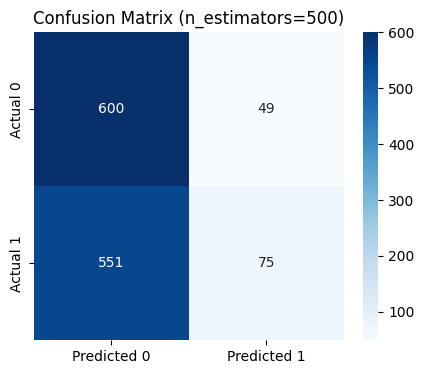

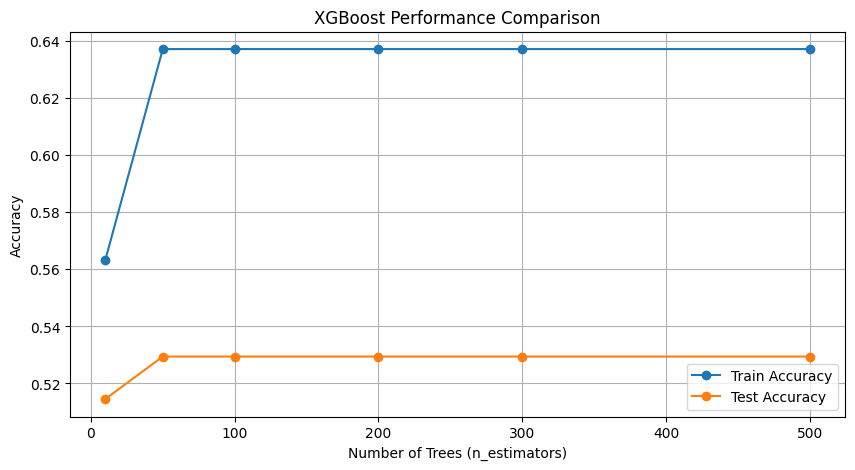

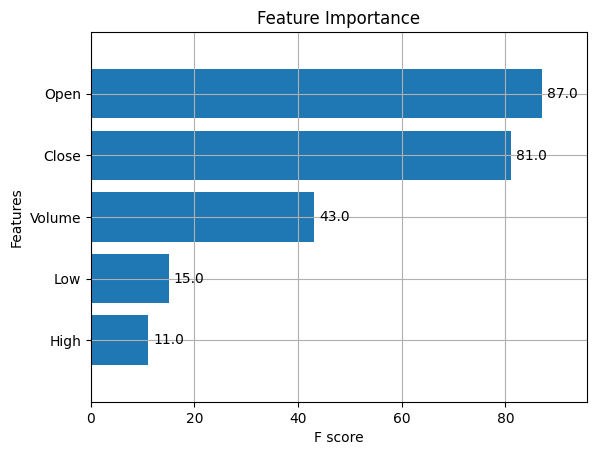

In [ ]:
split_idx = int(len(data) * 0.8)
X_train = data[predictors].iloc[:split_idx]
y_train = data['Target'].iloc[:split_idx]
X_test = data[predictors].iloc[split_idx:]
y_test = data['Target'].iloc[split_idx:]

params = {
    'learning_rate': 0.1,
    'max_depth': 3,
    'min_child_weight': 5,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'gamma': 0.1,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': 1
}

n_estimators = [10, 50, 100, 200, 300, 500]
train_accuracies = []
test_accuracies = []

for n in n_estimators:

    model = xgb.XGBClassifier(
        n_estimators=n,
        **params,
        early_stopping_rounds=10,
        eval_metric='logloss'
    )

    model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=False
    )

    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)

    train_acc = accuracy_score(y_train, train_preds)
    test_acc = accuracy_score(y_test, test_preds)

    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)


    print(f"n_estimators={n}:")
    print(f"Train Accuracy = {train_acc:.4f}, Test Accuracy = {test_acc:.4f}")

    cm = confusion_matrix(y_test, test_preds)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.title(f'Confusion Matrix (n_estimators={n})')
    plt.show()

plt.figure(figsize=(10, 5))
plt.plot(n_estimators, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(n_estimators, test_accuracies, label='Test Accuracy', marker='o')
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('Accuracy')
plt.title('XGBoost Performance Comparison')
plt.legend()
plt.grid(True)
plt.show()

xgb.plot_importance(model, height=0.8, title='Feature Importance')
plt.show()

In [ ]:
def sliding_window_backtest(data, model, predictors, window_size=30, step=1):
    all_results = []
    scaler = StandardScaler()
    for start in range(0, len(data) - window_size, step):
        train = data.iloc[start:start+window_size].copy()
        test = data.iloc[start+window_size:start+window_size+1].copy()
        if len(test) == 0:
            break
        train = add_technical_indicators(train)
        test = add_technical_indicators(test)
        train = handle_missing_data(train)
        test = handle_missing_data(test)
        available_predictors = [col for col in predictors if col in train.columns]
        additional_predictors = [col for col in train.columns if col not in ['Target', 'Tomorrow', 'date']
                                 and col not in available_predictors and not pd.isna(train[col]).any()]
        enhanced_predictors = available_predictors + additional_predictors
        X_train = train[enhanced_predictors]
        y_train = train['Target']
        X_test = test[enhanced_predictors]
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        if y_train.mean() < 0.4:
            try:
                smote = SMOTE(random_state=42)
                X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)
                model.fit(X_train_resampled, y_train_resampled)
            except:
                model.fit(X_train_scaled, y_train)
        else:
            model.fit(X_train_scaled, y_train)
        proba = model.predict_proba(X_test_scaled)[:, 1]
        test_result = test.copy()
        test_result['Probability'] = proba
        all_results.append(test_result)
    return pd.concat(all_results)

results_15 = sliding_window_backtest(data, best_model, best_features, window_size=15)
results_30 = sliding_window_backtest(data, best_model, best_features, window_size=30)

In [32]:
def sliding_window_backtest(data, model, predictors, window_size=30, step=1):
    all_results = []
    scaler = StandardScaler()
    for start in range(0, len(data) - window_size, step):
        train = data.iloc[start:start+window_size].copy()
        test = data.iloc[start+window_size:start+window_size+1].copy()
        if len(test) == 0 or len(train) == 0:
            print(f"Skip: train/test vide à l'itération {start}")
            continue

        train = add_technical_indicators(train)
        test = add_technical_indicators(test)
        train = handle_missing_data(train)
        test = handle_missing_data(test)

        available_predictors = [col for col in predictors if col in train.columns]
        additional_predictors = [
            col for col in train.columns
            if col not in ['Target', 'Tomorrow', 'date']
            and col not in available_predictors
            and not pd.isna(train[col]).any()
        ]
        enhanced_predictors = available_predictors + additional_predictors

        missing_cols_train = [col for col in enhanced_predictors if col not in train.columns]
        missing_cols_test = [col for col in enhanced_predictors if col not in test.columns]
        if missing_cols_train or missing_cols_test:
            print(f"Skip: colonnes manquantes à l'itération {start} : {missing_cols_train + missing_cols_test}")
            continue

        if train[enhanced_predictors].isnull().any().any() or test[enhanced_predictors].isnull().any().any():
            print(f"Skip: NaN dans features à l'itération {start}")
            continue

        X_train = train[enhanced_predictors]
        y_train = train['Target']
        X_test = test[enhanced_predictors]

        if X_train.shape[0] == 0 or X_test.shape[0] == 0:
            print(f"Skip: X_train ou X_test vide à l'itération {start}")
            continue

        try:
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
        except Exception as e:
            print(f"Skip: erreur scaling à l'itération {start} : {e}")
            continue

        if y_train.mean() < 0.4 and X_train_scaled.shape[0] > 1:
            try:
                smote = SMOTE(random_state=42)
                X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)
                model.fit(X_train_resampled, y_train_resampled)
            except Exception as e:
                print(f"SMOTE fail à l'itération {start} : {e}")
                model.fit(X_train_scaled, y_train)
        else:
            model.fit(X_train_scaled, y_train)
        try:
            proba = model.predict_proba(X_test_scaled)[:, 1]
        except Exception as e:
            print(f"Skip: erreur predict_proba à l'itération {start} : {e}")
            continue
        test_result = test.copy()
        test_result['Probability'] = proba
        all_results.append(test_result)
    if all_results:
        return pd.concat(all_results)
    else:
        print("Aucune fenêtre valide trouvée : vérifiez vos données et features.")
        return pd.DataFrame()

In [ ]:
def sliding_window_backtest(data, model, predictors, window_size=30, step=1, threshold=0.6):
    all_results = []
    scaler = StandardScaler()
    for start in range(0, len(data) - window_size - 1, step):
        train = data.iloc[start:start+window_size].copy()
        test = data.iloc[start+window_size:start+window_size+1].copy()
        if len(test) == 0 or len(train) == 0:
            continue
        X_train = train[predictors]
        y_train = train['Target']
        X_test = test[predictors]

        if X_train.isnull().any().any() or X_test.isnull().any().any():
            continue
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        model.fit(X_train_scaled, y_train)
        proba = model.predict_proba(X_test_scaled)[:, 1]
        pred = (proba >= threshold).astype(int)
        test_result = test.copy()
        test_result['Probability'] = proba
        test_result['Predictions'] = pred
        all_results.append(test_result)
    if all_results:
        return pd.concat(all_results)
    else:
        print("Aucune fenêtre valide trouvée.")
        return pd.DataFrame()

In [36]:
results_30 = sliding_window_backtest(data, best_model, predictors, window_size=30, threshold=0.6)
print(results_30[['Close', 'Target', 'Predictions', 'Probability']].tail())

      Close  Target  Predictions  Probability
6428  96.37       0            0     0.498421
6429  88.31       0            0     0.483743
6430  83.62       0            0     0.491746
6431  81.50       0            0     0.510179
6432  80.25       0            0     0.508065


In [37]:
results_30 = sliding_window_backtest(data, best_model, predictors, window_size=30, threshold=0.5)
print(results_30[['Close', 'Target', 'Predictions', 'Probability']].tail())

      Close  Target  Predictions  Probability
6428  96.37       0            0     0.498421
6429  88.31       0            0     0.483743
6430  83.62       0            0     0.491746
6431  81.50       0            1     0.510179
6432  80.25       0            1     0.508065


In [38]:
results_15 = sliding_window_backtest(data, best_model, predictors, window_size=15, threshold=0.45)
print(results_15[['Close', 'Target', 'Predictions', 'Probability']].tail())

      Close  Target  Predictions  Probability
6428  96.37       0            0     0.498421
6429  88.31       0            0     0.483743
6430  83.62       0            0     0.491746
6431  81.50       0            1     0.510179
6432  80.25       0            1     0.508065


In [ ]:
results_15 = sliding_window_backtest(data, best_model, predictors, window_size=15, threshold=0.6)
print(results_15[['Close', 'Target', 'Predictions', 'Probability']].tail())

      Close  Target  Predictions  Probability
6428  96.37       0            0     0.502485
6429  88.31       0            0     0.491144
6430  83.62       0            0     0.493259
6431  81.50       0            0     0.491652
6432  80.25       0            0     0.505108


# CHATBOT

In [ ]:
class StockPredictionChatbot:
    def __init__(self, predictions_df, ticker="AAPL"):
        self.predictions = predictions_df
        self.ticker = ticker
        self.current_date = self.predictions.index[-1]
        self.confidence_threshold = 0.65  
        
        if hasattr(model, 'predict_proba'):
            try:
                self.probas = pd.Series(
                    model.predict_proba(self.predictions[predictors])[:, 1],
                    index=self.predictions.index, 
                    name="Probability"
                )
                self.predictions = pd.concat([self.predictions, self.probas], axis=1)
            except:
                print("Info: Pas de probabilités disponibles")
        
        if 'Tomorrow' in self.predictions.columns and 'Close' in self.predictions.columns:
            self.predictions['Change_Pct'] = ((self.predictions['Tomorrow'] - self.predictions['Close']) / 
                                             self.predictions['Close'] * 100)
        
        print(f"📈 Assistant de trading pour {self.ticker} prêt!")
        print("Commandes disponibles:")
        print("  - 'alerte': Afficher les alertes importantes")
        print("  - 'résumé': Résumé des prédictions récentes")
        print("  - 'demain': Prédiction pour la prochaine séance")
        print("  - 'performance': Évaluer la performance du modèle")
        print("  - 'sortir': Quitter le chatbot")
        print("\nQue voulez-vous savoir?")
    
    def get_input(self):
        return input("\n> ").lower().strip()
    
    def generate_response(self, user_input):
        if 'alerte' in user_input:
            return self.get_alerts()
        elif 'résumé' in user_input or 'resume' in user_input:
            return self.get_recent_summary()
        elif 'demain' in user_input:
            return self.get_next_prediction()
        elif 'performance' in user_input:
            return self.evaluate_model()
        elif 'sortir' in user_input or 'quitter' in user_input:
            return "exit"
        else:
            return ("Je ne comprends pas cette commande. Essayez 'alerte', 'résumé', 'demain', "
                   "'performance' ou 'sortir'.")
    
    def get_alerts(self):
        """Génère des alertes pour les mouvements importants prédits"""
        high_confidence_preds = self.predictions.tail(5)
        
        alerts = []
        
        for idx, row in high_confidence_preds.iterrows():
            date_str = pd.to_datetime(idx).strftime('%d/%m/%Y') if not isinstance(idx, pd.Timestamp) else idx.strftime('%d/%m/%Y')
            
            if 'Probability' in row:
                confidence = row['Probability'] if row['Predictions'] == 1 else 1 - row['Probability']
                confidence_str = f"{confidence:.1%}"
            else:
                confidence_str = "N/A"
                
            movement = ""
            if 'Change_Pct' in row:
                movement = f" ({row['Change_Pct']:.2f}%)"
                
            if row['Predictions'] == 1:
                alerts.append(f"🟢 {date_str}: HAUSSE prédite (conf: {confidence_str}){movement}")
            else:
                alerts.append(f"🔴 {date_str}: BAISSE prédite (conf: {confidence_str}){movement}")
        
        if not alerts:
            return "Aucune alerte significative pour le moment."
        
        return "ALERTES RÉCENTES:\n" + "\n".join(alerts)
    
    def get_recent_summary(self):
        """Résume les prédictions récentes"""
        recent = self.predictions.tail(10)
        up_count = recent['Predictions'].sum()
        down_count = len(recent) - up_count
        
        if up_count > down_count * 2:
            trend = "FORTEMENT HAUSSIÈRE"
        elif up_count > down_count:
            trend = "LÉGÈREMENT HAUSSIÈRE"
        elif down_count > up_count * 2:
            trend = "FORTEMENT BAISSIÈRE"
        elif down_count > up_count:
            trend = "LÉGÈREMENT BAISSIÈRE"
        else:
            trend = "NEUTRE"
            
        avg_change = "N/A"
        if 'Change_Pct' in recent.columns:
            predicted_up = recent[recent['Predictions'] == 1]['Change_Pct'].mean()
            predicted_down = recent[recent['Predictions'] == 0]['Change_Pct'].mean()
            avg_change = f"Hausse moy.: +{predicted_up:.2f}%, Baisse moy.: {predicted_down:.2f}%"
        
        summary = (f"RÉSUMÉ DES 10 DERNIERS JOURS:\n"
                  f"Tendance: {trend}\n"
                  f"Prédictions: {up_count} hausses, {down_count} baisses\n"
                  f"{avg_change}")
        
        return summary
    
    def get_next_prediction(self):
        """Affiche la prédiction pour le prochain jour de trading"""
        last_row = self.predictions.iloc[-1]
        date = self.predictions.index[-1]
        
        next_date = pd.to_datetime(date) + pd.Timedelta(days=1)
        next_date_str = next_date.strftime('%d/%m/%Y')
        
        if 'Probability' in last_row:
            confidence = last_row['Probability'] if last_row['Predictions'] == 1 else 1 - last_row['Probability']
            confidence_str = f"{confidence:.1%}"
        else:
            confidence = 0 
            confidence_str = "N/A"
            
        if last_row['Predictions'] == 1:
            emoji = "🟢"
            direction = "HAUSSE"
        else:
            emoji = "🔴"
            direction = "BAISSE"
            
        change_str = ""
        if 'Tomorrow' in last_row and 'Close' in last_row:
            change_pct = (last_row['Tomorrow'] - last_row['Close']) / last_row['Close'] * 100
            change_str = f"\nChangement prévu: {change_pct:.2f}%"
            
        message = (f"PRÉDICTION POUR {next_date_str}:\n"
                  f"{emoji} {direction} (confiance: {confidence_str}){change_str}")
        
        if last_row['Predictions'] == 1 and confidence > 0.65:
            message += "\n\nConseil: Envisager d'ACHETER"
        elif last_row['Predictions'] == 0 and confidence > 0.65:
            message += "\n\nConseil: Envisager de VENDRE"
        else:
            message += "\n\nConseil: ATTENDRE (confiance insuffisante)"
            
        return message
    
    def evaluate_model(self):
        """Évalue la performance du modèle"""
        if 'Target' in self.predictions.columns:
            accuracy = (self.predictions['Predictions'] == self.predictions['Target']).mean()
            precision = (self.predictions[self.predictions['Predictions'] == 1]['Target'] == 1).mean()
            
            initial_investment = 10000
            current_investment = initial_investment
            shares = 0
            
            for idx, row in self.predictions.iterrows():
                if row['Predictions'] == 1 and shares == 0:  # Acheter
                    shares = current_investment / row['Close']
                    current_investment = 0
                elif row['Predictions'] == 0 and shares > 0:  # Vendre
                    current_investment = shares * row['Close']
                    shares = 0
            
            if shares > 0:
                final_value = shares * self.predictions['Close'].iloc[-1]
            else:
                final_value = current_investment
                
            model_return = (final_value - initial_investment) / initial_investment * 100
            
            buy_hold_return = (self.predictions['Close'].iloc[-1] - self.predictions['Close'].iloc[0]) / self.predictions['Close'].iloc[0] * 100
            
            return (f"PERFORMANCE DU MODÈLE:\n"
                   f"Précision: {accuracy:.2%}\n"
                   f"Précision des hausses: {precision:.2%}\n\n"
                   f"Retour sur investissement:\n"
                   f"Stratégie modèle: {model_return:.2f}%\n"
                   f"Buy & Hold: {buy_hold_return:.2f}%\n"
                   f"Surperformance: {model_return - buy_hold_return:.2f}%")
        else:
            return "Impossible d'évaluer la performance sans données de référence."
    
    def run(self):
        """Exécute le chatbot en mode interactif"""
        while True:
            user_input = self.get_input()
            response = self.generate_response(user_input)
            
            if response == "exit":
                print("Au revoir! 👋")
                break
                
            print("\n" + response)

chatbot = StockPredictionChatbot(results_15)  
chatbot.run()

C:\Users\gabyd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Info: Pas de probabilités disponibles
📈 Assistant de trading pour AAPL prêt!
Commandes disponibles:
  - 'alerte': Afficher les alertes importantes
  - 'résumé': Résumé des prédictions récentes
  - 'demain': Prédiction pour la prochaine séance
  - 'performance': Évaluer la performance du modèle
  - 'sortir': Quitter le chatbot

Que voulez-vous savoir?

RÉSUMÉ DES 10 DERNIERS JOURS:
Tendance: FORTEMENT BAISSIÈRE
Prédictions: 0 hausses, 10 baisses
Hausse moy.: +nan%, Baisse moy.: -1.32%

PRÉDICTION POUR 02/01/1970:
🔴 BAISSE (confiance: 49.5%)
Changement prévu: -3.28%

Conseil: ATTENDRE (confiance insuffisante)

PERFORMANCE DU MODÈLE:
Précision: 52.68%
Précision des hausses: nan%

Retour sur investissement:
Stratégie modèle: 0.00%
Buy & Hold: -59.37%
Surperformance: 59.37%
Au revoir! 👋
